# Milestone 3: Random Forest Algorithm

**Authors**: __Khizer Zakir & Rodrigo Brust Santos__

__November 2023__

_____

In [3]:
#basic libraries
import pandas as pd
import numpy as np

#graphic and charts
import matplotlib.pyplot as plt
import seaborn as sns


#machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import  mean_squared_error, r2_score
from sklearn.model_selection import GroupKFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.feature_selection import RFECV
from boruta import BorutaPy
from sklearn.inspection import permutation_importance



# Table of Contents

1. Feedback

1. Hyperparameter Setting


2. Model Calibration


3.  Variable Selection


4. Model Evaluation


_____

In [4]:
#loading data frame
df = pd.read_csv('../dataset/stream_samples_basin_id.csv')

#removing columns that wont be used
df.drop(columns = ['geometry', 'index_right'], inplace = True)

df.rename(columns = {'OBJECTID':'basin_id'}, inplace = True)

df.head(2)

,x,y,Ag (ppm),Al (%),As (ppm),Ba (ppm),Be (ppm),Bi (ppm),Ca (%),Cd (ppm),...,Sr (ppm),Th (ppm),Ti (%),U (ppm),V (ppm),W (ppm),Y (ppm),Zn (ppm),Zr (ppm),basin_id
0,248757,7972050,0.03,2.63,4.0,76.0,1.0,0.31,0.05,0.03,...,3.3,7.4,0.03,0.70,73,0.3,13.15,27,6.3,2
1,244460,7973135,0.02,1.93,2.0,84.0,1.7,0.29,0.04,0.01,...,3.1,8.2,0.06,0.94,58,0.3,23.90,58,6.9,3


In [5]:
#variable that we will predict
Y_column = 'Zn (ppm)'

#explanatory variables
X_columns = list(df.iloc[:, :-1])
X_col = df[X_columns]

#dropping Zn from our explanatory variables
X_columns.remove('Zn (ppm)')

In [6]:
#generating the X and Y dataset and transforming to numpy array
X, Y = df[X_columns].to_numpy(), df[Y_column].to_numpy()

#defining the watershed number as the group
groups = df['basin_id'].to_numpy()


## 0. Cross-Validation Check 

Despite not receving Feedback on-time for the next submission deadline, we wanted to know if the CV performed before was correctly implemented.

Below, we are going to compare the results of CV. One implementing the same way as before, with `cross_val_predict` and another using a for loop.

#### How we implemented CV for Linear Regression

In [7]:
#These will be used in the whole notebook.

# Create a GroupKFold object with the desired number of splits (k)
k = 4 #setting the number of splits, arbitrarly.
group_kfold = GroupKFold(n_splits=k)

# Specify the fold you want to use (fold_index should be less than k)
fold_index = [1,2,3]

In [8]:
basin_kfold = group_kfold.split(X, Y, groups)

# Create a nested list of train and test indices for each fold
train_indices, test_indices = [list(traintest) for traintest in zip(*basin_kfold)]

basin_cv = [*zip(train_indices,test_indices)]

In [9]:
%%time

# model
linear_clf = LinearRegression().fit(X, Y)

# fit and predict at the same time consdering the cv = basin_cv takes care of the data splitting

y_pred = cross_val_predict(linear_clf, X, Y, cv=basin_cv, groups=groups)

r2 = r2_score(Y, y_pred)
rmse = mean_squared_error(Y, y_pred, squared = False)
mse = mean_squared_error(Y, y_pred)

print('R2: ',round(r2,2))
print(f'RMSE:', round(rmse,2))
print(f'MSE:', round(mse,2))

R2:  0.57
RMSE: 13.68
MSE: 187.13
CPU times: total: 62.5 ms
Wall time: 64 ms


### How we are testing right now LinearRegression model with CV and for loop.

In [10]:
%%time

r2_scores, mse_scores, rmse_scores = [], [], []

for i in fold_index:

    # Get indices for the specified fold
    train_index, test_index = list(group_kfold.split(X, Y, groups))[i - 1]

    #print('Train-Test Shapes', train_index.shape, test_index.shape)

    # Use the indices to get the training and testing sets
    X_train, X_test = X[train_index], X[test_index]

    #print('X Train-Test Shapes', X_train.shape, X_test.shape)

    y_train, y_test = Y[train_index], Y[test_index]
    #print('Y Train-Test Shapes', y_train.shape, y_test.shape)

    # Create a linear regression model
    model = LinearRegression()

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred_two = model.predict(X_test)

    # Evaluate the model
    r2 = r2_score(y_test, y_pred_two)
    rmse = mean_squared_error(y_test, y_pred_two, squared=False)
    mse = mean_squared_error(y_test, y_pred_two)

    print(f'R2 - Index: {i} ',round(r2,2))
    print(f'RMSE:', round(rmse,2))
    print(f'MSE:', round(mse,2))

    r2_scores.append(r2)
    mse_scores.append(mse)
    rmse_scores.append(rmse)

R2 - Index: 1  0.53
RMSE: 15.31
MSE: 234.27
R2 - Index: 2  0.62
RMSE: 14.14
MSE: 199.84
R2 - Index: 3  0.55
RMSE: 11.66
MSE: 135.84
CPU times: total: 15.6 ms
Wall time: 32 ms


In [11]:
print('Linear Regression Model with CV in a For Loop')

print('R2: ',round(np.mean(r2_scores),2))
print(f'RMSE:', round(np.mean(rmse_scores),2))
print(f'MSE:', round(np.mean(mse_scores),2))

Linear Regression Model with CV in a For Loop
R2:  0.56
RMSE: 13.7
MSE: 189.99


If we compare the values of the for-loop and `cross_val_predict`, we can see there's a very small variation in the values.

| Metric                 | LR - Loop CV              | LR - cross_val_predict()               | Percentual Difference |
|------------------------|-----------------------|-----------------------|-----------------------|
| R2                     | 0.56                  | 0.57                  | +1.79%                |
| MSE                    | 189.99                | 187.13                | -1.51%                |
| RMSE                   | 13.7                  | 13.68                 | -0.15%                |


### Now let's test with Ridge Model with CV in a for-loop

In [12]:
#using the optimal learning rate
r_rmse, r_mse, r_r2 = [], [], []
for i in fold_index:

    # Get indices for the specified fold
    train_index, test_index = list(group_kfold.split(X, Y, groups))[i - 1]

    # Use the indices to get the training and testing sets
    X_train, X_test = X[train_index], X[test_index]


    y_train, y_test = Y[train_index], Y[test_index]

    elastmodel = Ridge(alpha=4.83)

    elastmodel.fit(X_train, y_train)

    y_pred_ridge = elastmodel.predict(X_test)

    # Calculate evaluation metrics
    rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False)
    mse_ridge = mean_squared_error(y_test, y_pred_ridge)
    r2_ridge = r2_score(y_test, y_pred_ridge)

    r_rmse.append(rmse_ridge)
    r_mse.append(mse_ridge)
    r_r2.append(r2_ridge)

    print(f'Index {i}', r2_ridge, rmse_ridge, mse_ridge )

Index 1 0.5959173014095739 14.19358526782089 201.45786275490218
Index 2 0.6461940686823625 13.5744030918268 184.26441929939702
Index 3 0.5278142409741016 11.880613713672371 141.14898221350003


In [13]:
print('Ridge Model with CV in a For Loop')

print('R2: ',round(np.mean(r_r2),2))
print(f'RMSE:', round(np.mean(r_rmse),2))
print(f'MSE:', round(np.mean(r_mse),2))

Ridge Model with CV in a For Loop
R2:  0.59
RMSE: 13.22
MSE: 175.62


Once again, the values show an insignificant variation in the metrics.

| Metric                 | Ridge CV Loop           | Ridge cross_val_predict()      | Percentual Difference |
|------------------------|-----------------------|-----------------------|-----------------------|
| R2                     | 0.59                  | 0.59                  | 0.00%                 |
| MSE                    | 175.62                | 176.97                | +0.76%                |
| RMSE                   | 13.22                 | 13.30                 | +0.60%                |



Having in mind that the way we implemented and this other approach are quite the same, we are more tranquil to keep on going with the Random Forest model implementation.

We are sticking to the `cross_val_predict()` function whenever it is possible. Other times, it will be necessary to extract more information at each loop of the cross-validation, explaining why the for-loop will also be used in some cases.
_____

## 2. Creating a Random Forest

• Recall what are the two most important hyperparameters. Propose a protocol that relies on the out-of-bag
(OOB) error to tune this hyperparameter.

The two most important hyperparameters for the random forest algorithm are:

- `max_features`: helps controlling the bias and variance for the forest. In case of having a small number of features, the trees are less correlated. By default, in regression problems, max_features starts with `d/3`, until being properly tuned.

- `n_estimators`: represents the amount of forests within the random forest. It's recommended starting with a high value in order to obtain a robust estimate.


First, the model will be implemented without any type of hyperparameter setting. Then, the main hyperparameters will be calculated, leading to the application to the model. Finaly, it will be visible the difference between the random forest tuned and the other that is not.


In [14]:
#maxfeatures
d = round(df.shape[0]/3)

Below, we are setting the `RandomForestRegressor` within the variable `tree_clf`.

The `n_estimators` was set as 500 arbitrarly. The ideia is that if there is a high value it's possible to get a stable estimate, and then change it to the tuned value.

`max_features` was set as the division of the length of the dataset by 3. Also to be tuned.

It was opted to have out-of-bag replacement to have an estimation of the generalization score.

Finally, the `random_state` was set to 42 in order to get the reproducibility.

In [15]:
tree_clf = RandomForestRegressor(n_estimators= 500, 
                                 max_features=d, 
                                 oob_score=True, 
                                 random_state=42)

In [16]:
#fitting data
tree_clf.fit(X_train, y_train)

RandomForestRegressor(max_features=236, n_estimators=500, oob_score=True,
                      random_state=42)

In [17]:
#getting parameters of the tree
tree_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 236,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': True,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [19]:
oob_score = round(tree_clf.oob_score_,2)

print('OOB score: ', oob_score )


OOB score:  0.67


Based on `OOB score`, our model predicts correctly about 67% of the samples out-of-bag.

In [20]:
pred_test = tree_clf.predict(X_test)

# Calculate evaluation metrics
rmse_tree_clf = mean_squared_error(y_test, pred_test, squared=False)

mse_tree_clf = mean_squared_error(y_test, pred_test)

r2_tree_clf = r2_score(y_test, pred_test)

print('Random Forest Regressor Scores without hyperparameter tunning')
print('#############################################################')
print('R2 Score:', round(r2_tree_clf,2))
print('MSE:', round(mse_tree_clf,2))
print('RMSE:', round(rmse_tree_clf,2))
print('#############################################################')

Random Forest Regressor Scores without hyperparameter tunning
#############################################################
R2 Score: 0.64
MSE: 107.81
RMSE: 10.38
#############################################################


## 2. Hyperparameter Setting & Model Calibration

• For the calibrated model, measure the importance of each variable. Justify the choice of the importance
measure (why did you use this importance measure instead of another one?). Comment on the results:
according to the importance measure you chose, what are the most discriminant variables of your dataset?
Interpret

Justifying the parameters below:

- `warm_start`: to allow the reutilization of previous run, leading to the addition of more estimators to the ensable. **Explain it better maybe?**

- `max_features='auto'`: once the **n_estimators** is tuned, the next one to be tuned is the max_features. For now, let's keep it in auto.

In [17]:
error_rate_1 = []

min_estimators = 500
max_estimators = 4000
step = 50

for i in range(min_estimators, max_estimators+1, step):
    rf_reg = RandomForestRegressor(warm_start=True, n_estimators= i, max_features=1.0, random_state=42, oob_score=True)

    rf_reg.fit(X_train, y_train)

    # Record the OOB error for each `n_estimators=i` setting.
    oob_error = 1 - rf_reg.oob_score_

    error_rate_1.append(oob_error)

KeyboardInterrupt: 

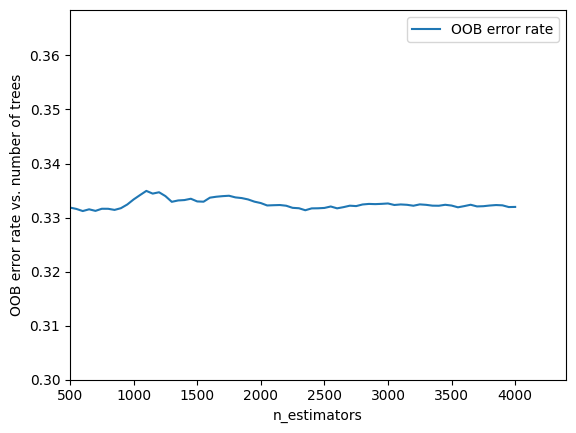

In [29]:
# Error Rate x n_estimators
plt.plot(range(min_estimators,
            max_estimators +1,
            step
              ), 
        error_rate_1, 
        label="OOB error rate"
        )

plt.ylim(0.30, 1.1*max(error_rate_1))
plt.xlim(min_estimators, 1.1*max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate vs. number of trees")
plt.legend(loc="upper right")
plt.show()

Since the OOB error rate is almost flat around 2000 n_estimators, this is the value that will be used.

In [21]:
grid = {'max_features':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]}

# create the forest model to tune
rf = RandomForestRegressor(n_estimators=2000) 

B=5 #number of iterations
results_cv=pd.DataFrame()
for i in range(B):

    rf_cv = GridSearchCV(estimator=rf,
                         param_grid=grid, 
                         cv=basin_cv,
                         n_jobs=-1
                         )

    rf_cv.fit(X, Y) # Fit the CV search
    if i==0:
        results_cv=pd.DataFrame(rf_cv.cv_results_)[["params",
                                                    "mean_test_score",
                                                    "std_test_score"]]
    else:
        results_cv["mean_test_score"]=results_cv["mean_test_score"]+pd.DataFrame(rf_cv.cv_results_)["mean_test_score"]
        results_cv["std_test_score"]=results_cv["std_test_score"]+pd.DataFrame(rf_cv.cv_results_)["std_test_score"]


results_cv["mean_test_score"]=results_cv["mean_test_score"]/B
results_cv["std_test_score"]=results_cv["std_test_score"]/B

print(results_cv)

                  params  mean_test_score  std_test_score
0  {'max_features': 0.1}         0.643443        0.051902
1  {'max_features': 0.2}         0.657936        0.051251
2  {'max_features': 0.3}         0.660969        0.053202
3  {'max_features': 0.4}         0.658543        0.057185
4  {'max_features': 0.5}         0.656734        0.058457
5  {'max_features': 0.6}         0.651456        0.062576
6  {'max_features': 0.7}         0.646503        0.066120
7  {'max_features': 0.8}         0.641971        0.070297
8  {'max_features': 0.9}         0.635826        0.074615


The best `max_feature` value is the one that has the lowest standard deviation score. In this case, the best value is **0.2**

In [22]:
error_rate = []

min_estimators = 500
max_estimators = 4000
step = 50

for i in range(min_estimators, max_estimators+1, step):

    rf_reg = RandomForestRegressor(warm_start=True, 
                                   n_estimators= i, 
                                   max_features=0.2, 
                                   random_state=42, 
                                   oob_score=True)

    rf_reg.fit(X_train, y_train)

    # Record the OOB error for each `n_estimators=i` setting.
    oob_error = 1 - rf_reg.oob_score_

    error_rate.append(oob_error)

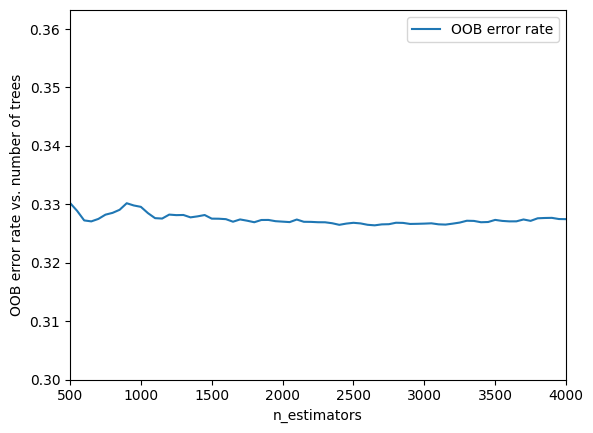

In [23]:
# Error Rate x n_estimators

plt.plot(range(min_estimators, 
               max_estimators +1, 
               step
        ), 
        error_rate, 
        label="OOB error rate")

plt.ylim(0.30, 1.1*max(error_rate))
plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate vs. number of trees")
plt.legend(loc="upper right")
plt.show()

______

Now that the hyperparameters of `n_estimators` and `max_features` are known, let's run a model with these optimal values.

Remembering that we have the spatial autocorrelation with the samples, we are still keep on going with the `GroupKFold` strategy, separating our samples by the watershed id.

As said in **Milestone 2**, `k = 4` was an arbitrary choice.

In [21]:
# model
opt_rf = RandomForestRegressor(n_estimators = 2000, 
                               max_features=0.2, 
                               oob_score=True, 
                               random_state=42)

# fit and predict at the same time consdering the cv = basin_cv takes care of the data splitting

y_pred = cross_val_predict(opt_rf, X, Y, cv=basin_cv, groups=groups)

r2_clf = r2_score(Y, y_pred)
rmse_clf = mean_squared_error(Y, y_pred, squared = False)
mse_clf = mean_squared_error(Y, y_pred)

#metrics
print('Results with Random Forest Regressor with\nOptimal Hyperparameters and with GroupKFold CV:')
print('R2: ',round(r2_clf,2))
print(f'RMSE:', round(rmse_clf,2))
print(f'MSE:', round(mse_clf,2))

Results with Random Forest Regressor with
Optimal Hyperparameters and with GroupKFold CV:
R2:  0.67
RMSE: 12.03
MSE: 144.8


#### Interpretation

Performing the cross-validation with the RandomForestRegressor and Optimal Hyperparameters improved the R2 when compared to the Linear Regression Model and Ridge Model - what was already expected. When comparing with the non tunned hyperparameters, it had 1% improvement in the R2, and small variations in RMSE and MSE.

So far, the model have a moderated-to-good explanation of the variance in the target variable.

## 3. Variable Selection

#### Feature importance across folds

The `RandomForestRegressor` model produced good results with respect to our evaluation metrics. Especially, after parameter tuning - Model Calibration. This section explores the importance of respective variables using feature_importance methods. There are number of methods to estimate the feature importance, we are going to use the permutation importance method. There are a couple of reasons for that: 

- This is something we have learned and looked promising in describing the importance of some variables
- It is a model-agnositic method.
- unlike the `model.feature_importance_` method (another method we have studied during the course), it does not have the tendency to "prefer features with high cardinality" [Piotr Płoński](https://mljar.com/blog/feature-importance-in-random-forest/#:~:text=The%20feature%20importance%20(variable%20importance,by%20employing%20the%20feature%20selection.))

- It is also necessary to mention that this method is computationally expensive compared to the other method, but it will compensate that with better results. 

To stay consistent with our approach, we are going to loop the `permutation importance` for the same clf model we have calibrated recently with `k-fold = 4`. 

In [ ]:
# using the same model to find the feature importance using group kfold
clf = RandomForestRegressor(n_estimators=2000, 
                            max_features=0.2, 
                            oob_score=True, 
                            random_state=42) 

# Lists to store feature importances for each fold

#feature_importance_per_fold = []
permutation_importance_per_fold = []


for train_index, test_index in group_kfold.split(X, Y, groups):
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    # For training, fit() is used
    clf.fit(X_train, y_train)

    # Feature importance for the current fold
    #fold_feature_importance = clf.feature_importances_
    #feature_importance_per_fold.append(fold_feature_importance)

    # Permutation importance for the current fold
    per_imp_result = permutation_importance(
        estimator=clf,
        X=X_test,
        y=y_test,
        scoring ='neg_mean_squared_error',  
        n_repeats=50,
        random_state=42
    )
    permutation_importance_per_fold.append(per_imp_result.importances_mean)
    
# scoring='neg_mean_squared_error' in permutation_importance, it means that the algorithm will evaluate the model's performance based on the
# negative mean squared error when assessing the importance of each feature to see how much the model's performance decreases when a feature is not available.

### Permutation importance

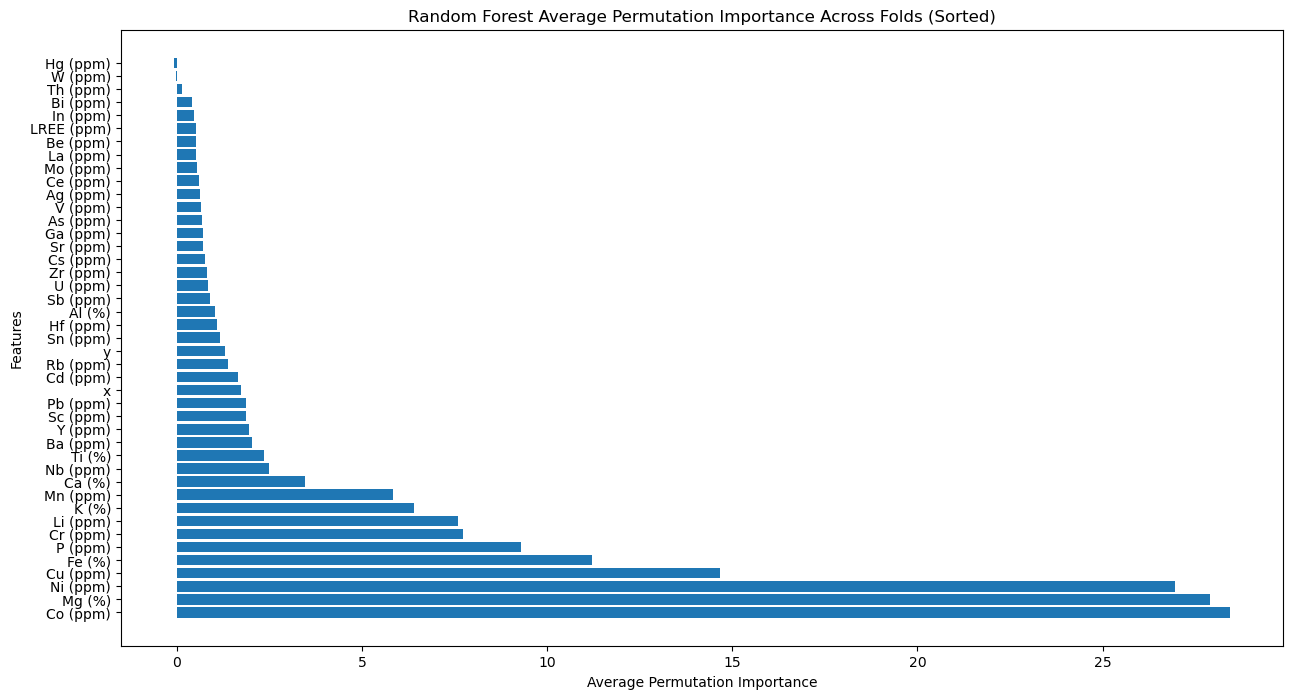

In [137]:

# mean permutation importance across folds
mean_permutation_importance = np.mean(permutation_importance_per_fold, axis=0)

# sorting the mean permutation importance

sorted_permutation_indices = np.argsort(mean_permutation_importance)[::-1]
sorted_permutation_feature_names = np.array(X_columns)[sorted_permutation_indices]

# Plotting sorted mean permutation importance
plt.figure(figsize=(15, 8))
plt.barh(range(len(
                    mean_permutation_importance
                    )
                ), 
                mean_permutation_importance[sorted_permutation_indices], 
                align='center')

plt.yticks(range(len(
                        mean_permutation_importance
                        )
                    ), 
                    sorted_permutation_feature_names)

plt.xlabel('Average Permutation Importance')
plt.ylabel('Features')
plt.title('Random Forest Average Permutation Importance Across Folds (Sorted)')
plt.show()


In [135]:
# Top 20 features based on mean permutation importance
top_20_permutation_importance = sorted_permutation_feature_names[:20]

# Print or use the top 20 features
print("Top 20 Features based on Mean Permutation Importance:", top_20_permutation_importance)

Top 20 Features based on Mean Permutation Importance: ['Co (ppm)' 'Mg (%)' 'Ni (ppm)' 'Cu (ppm)' 'Fe (%)' 'P (ppm)' 'Cr (ppm)'
 'Li (ppm)' 'K (%)' 'Mn (ppm)' 'Ca (%)' 'Nb (ppm)' 'Ti (%)' 'Ba (ppm)'
 'Y (ppm)' 'Sc (ppm)' 'Pb (ppm)' 'x' 'Cd (ppm)' 'Rb (ppm)']


#### Interpretation

This model-agnostic method has estimated the MDA on all the 43 variables `n__repeats` = 50 times on the test set (using each time another permutation of each feature). The selection of top 20 variables is a detour after looking at the outcome of `REFCV`. This feature selection algorithm gave 20 optimal features to improve the model. In order to compare the top 20 from both the methods we have filtered the top 20 in this step. 

This permutation importance is not any concluding remark rather a qualitative measure to understand the most important features for the model in general. However, this is a good and simple initial step to have an idea to select optimal features with more concerete algorithms like, REF and REFCV. 
____

### REFCV 

`RFECV` (Recursive Feature Elimination with Cross-Validation) iteratively evaluates subsets of features and selects the optimal subset based on cross-validated performance. It can help in identifying a more compact set of features that still captures the essential information needed for model performance. [Sklearn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html)

In [77]:

rfecv = RFECV(estimator=clf, 
              step=1, 
              cv=group_kfold, 
              scoring='neg_mean_squared_error')

rfecv.fit(X, Y, groups=groups)


RFECV(cv=GroupKFold(n_splits=4),
      estimator=RandomForestRegressor(max_features=0.2, n_estimators=2000,
                                      oob_score=True, random_state=42),
      scoring='neg_mean_squared_error')

In [78]:
rfecv.cv_results_["mean_test_score"]

array([-342.78554347, -219.72920419, -186.274189  , -172.62540342,
       -168.04955873, -163.79656813, -165.81732068, -163.26298185,
       -158.92292521, -151.97372394, -151.02698534, -151.56680788,
       -147.42205498, -148.21003878, -145.04613502, -144.52797604,
       -143.73780176, -143.43419746, -143.26978562, -140.55825681,
       -141.62885845, -141.97726316, -142.07531655, -143.15323959,
       -141.51046694, -142.361178  , -143.1525851 , -143.79427309,
       -143.5001967 , -144.02040461, -143.39252062, -144.04735257,
       -142.87226572, -143.45684628, -143.39089936, -144.01991214,
       -144.22903361, -144.20998467, -145.09306107, -143.75619556,
       -145.04260712, -145.05615949, -144.72842991])

#### Interpretation

The `rfecv.cv_results_["mean_test_score"]` gives a better perspective on the evaluation criteria of this method. The highest the value with the negative sign the more important is the variable. As soon as you eliminate that variable from the model, the performance deteriorates. 

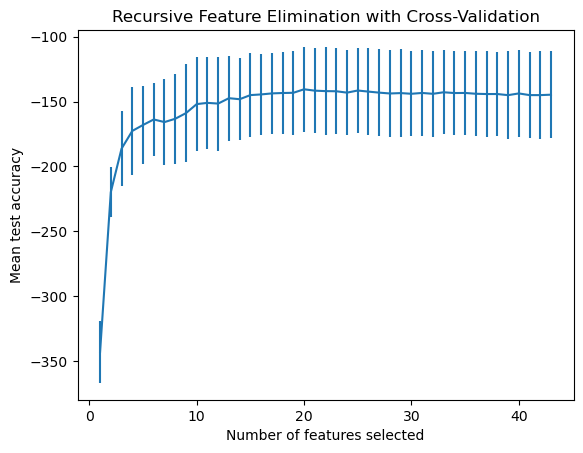

In [138]:
## This plot has been adopted from the sklearn documentation page

min_features_to_select = 1
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination with Cross-Validation")
plt.show()

In [58]:

print("Number of selected features:", rfecv.n_features_)


Number of selected features: 20


In [94]:
subset_rfecv = [f for f, s in zip(X_columns, rfecv.support_) if s]



Selected features: ['x', 'y', 'Ba (ppm)', 'Ca (%)', 'Co (ppm)', 'Cr (ppm)', 'Cu (ppm)', 'Fe (%)', 'K (%)', 'Li (ppm)', 'Mg (%)']


In [95]:
# Get the selected features and their rankings
selected_features = np.array(X_columns)[rfecv.support_]
selected_features

array(['x', 'y', 'Ba (ppm)', 'Ca (%)', 'Co (ppm)', 'Cr (ppm)', 'Cu (ppm)',
       'Fe (%)', 'K (%)', 'Li (ppm)', 'Mg (%)', 'Mn (ppm)', 'Nb (ppm)',
       'Ni (ppm)', 'P (ppm)', 'Pb (ppm)', 'Rb (ppm)', 'Sn (ppm)',
       'Ti (%)', 'Y (ppm)'], dtype='<U10')

#### Interpretation

The RFECV model selected only 20 features, it is justified by the plot. As we can see that the mean test accuracy plateaus at around 20 num of features and that is the optimal number of features considered here. 
____

### Intersection between permutation importance and RFECV

This is the purpose of finding the top 20 variables in the earlier step from the permutation importance method. So, we can compare and see how well did our permutation do to find the top most important features. 

These intersecting variables signify that they are relatively more importance than the other variables as they stands out in both the methods, this can help us reduce the number of features further (make another subset of X) to evaluate the performance and compare. 

*Note*: we may not consider the option of applying the model with the optimal(reduced number of features) for this milestone. We have planned it for the next milestone as an additional/continual task from this. 

In [139]:
# Convert the lists to sets for set operations
set_top_20_permutation = set(top_20_permutation_importance)
set_rfecv_selected = set(subset_rfecv)

# Find the intersection
intersection_vars = set_top_20_permutation.intersection(set_rfecv_selected)
print(len(intersection_vars))
# Print or use the intersection variables
print("Intersection Variables:", intersection_vars)

18
Intersection Variables: {'Ca (%)', 'Cr (ppm)', 'Pb (ppm)', 'Nb (ppm)', 'Mn (ppm)', 'Ni (ppm)', 'Co (ppm)', 'x', 'Cu (ppm)', 'Li (ppm)', 'P (ppm)', 'Fe (%)', 'K (%)', 'Mg (%)', 'Ba (ppm)', 'Rb (ppm)', 'Ti (%)', 'Y (ppm)'}


### Fitness of the model for top variables from REFCV

In [69]:

# Fit a new model based on feature selection
X_selected = rfecv.transform(X)

# Fit a new model based on the selected features
clf_selected = RandomForestRegressor(n_estimators=2000, 
                                     max_features=0.2, 
                                     oob_score=True, 
                                     random_state=42)
clf_selected.fit(X_selected, Y)

RandomForestRegressor(max_features=0.2, n_estimators=2000, oob_score=True,
                      random_state=42)

In [89]:
%%timeit

# it might be computationally expensive to run this cell but it is important
# to distinguish the difference between the model with all the features and the model with the selected features
clf_selected = RandomForestRegressor(n_estimators=2000, 
                                    max_features=0.2, 
                                    oob_score=True, 
                                    random_state=42) 



# Lists to store metrics for each fold
r2_scores_selected = []
rmse_scores_selected = []
mse_scores_selected = []

for train_index, test_index in group_kfold.split(X_selected, Y, groups):
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train_selected, X_test_selected = X_selected[train_index], X_selected[test_index]
    y_train, y_test = Y[train_index], Y[test_index]


    clf_selected.fit(X_train_selected, y_train)

    r2_score_selected = clf_selected.score(X_test_selected, y_test)
    r2_scores_selected.append(r2_score_selected)

    
    y_pred_selected = clf_selected.predict(X_test_selected)

    rmse_selected = mean_squared_error(y_test, y_pred_selected, squared=False)
    rmse_scores_selected.append(rmse_selected)

    mse_selected = mean_squared_error(y_test, y_pred_selected)
    mse_scores_selected.append(mse_selected)
  

In [140]:
# compute average metrics across folds
avg_r2_score_selected = np.mean(r2_scores_selected)
avg_rmse_selected = np.mean(rmse_scores_selected)
avg_mse_selected = np.mean(mse_scores_selected)


print("Average R2 Score (Selected Features):", round(avg_r2_score_selected,2))
print("Average Root Mean Squared Error (RMSE) (Selected Features):", round(avg_rmse_selected,2))
print("Average Mean Squared Error (MSE) (Selected Features):", round(avg_mse_selected,2))

Average R2 Score (Selected Features): 0.6685506120647016
Average Root Mean Squared Error (RMSE) (Selected Features): 11.76179003427273
Average Mean Squared Error (MSE) (Selected Features): 140.06258460635473


#### Interpretation

The result hasn't improved a long way however the processing time has decreased significantly. There is always a compromise between computation price and accuracy, but in this case you are better off with both. 
Also, the performance on the model with reduced variable has improved a slight bit. $r^2$ increase from `0.65` to `0.67` and the `avg.mse` has also been dropped from `MSE:144.73` to `MSE: 140.06`



This might look very repetitive but it is important to see the all the process at one stop for better visualiation and better understanding. First model takes all the features into account, while the other only values 20 variables based on the `REFCV` algorithm.


## 4. Model Evaluation:

Overall, the models had similar results, as shown in the table below: 

| Metric                                           | RFR (Optimal Hyperparameters) | RFR (No Hyperparameter Tuning) | RFR RFCV (Selected Features) |
|---------------------------------------------------|---------------------------------------------------|------------------------------------------------------|----------------------------------------|
| R2 Score                                          | 0.67                                              | 0.64                                                 | 0.67                                  |
| Mean Squared Error (MSE)                          | 144.8                                            | 107.81                                               | 140.06                                 |
| Root Mean Squared Error (RMSE)                    | 12.03                                             | 10.38                                                | 11.76                                  |


The feature selection made the runtime of the model reduced drastically. Meanwhile the `opt_clf` took a couple of minutes to run, the others were faster. We timed both the models to evaluate them on time:


**RandomForestRegressor with all features**

- Model with all the features: `58.8 s ± 269 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)`

**RandomForestRegressor with selected features**

- Model with reduced features: `40.7 s ± 9.49 s per loop (mean ± std. dev. of 7 runs, 1 loop each)` for the model evaluation

The results did not change much when comparing several RF. However, there was an improvement in terms of processing time. 

It is important to highlight that the complexity of data could be holding the model back. An interesting approach for improving the performance is adding more variables, such as lithology.

One thing regarding the MSE: as out metrics, we see that it's always a very high value. However, it's important to look at our target data. The whole dataset of Zn (ppm) have an average of 37.6 ppm, the minimum is 3 and maximum 194. The 3rd quantile have 47ppm. Since we have a lot of variance, and the MSE penalizes large errors, this might justify why we are having high MSE values for all of our models.

_____

References:

https://machinelearningmastery.com/an-introduction-to-feature-selection/

https://machinelearningmastery.com/feature-selection-machine-learning-python/
https://www.datatechnotes.com/2022/10/feature-selection-example-with-rfecv-in.html#:~:text=RFECV%20(Recursive%20Feature%20Elimination%20with,features%20in%20a%20given%20dataset.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html

About the cv method:

https://scikit-learn.org/stable/glossary.html#term-CV-splitter

Stackoverflow support: https://stackoverflow.com/questions/44487654/build-a-random-forest-regressor-with-cross-validation-from-scratch

https://medium.com/wicds/feature-importance-feature-selection-acac802ba565